Deep learning for natural-language processing is pattern recognition applied to words, sentences, and paragraphs, in much the same way that computer vision is pattern recognition applied to pixels.


**Vectorizing text** is the process of transforming text into numeric tensors, can be done by:
- Segment text into words, and transform each word into a vector
- Segment text into characters, and transform each charactor into a vector
- Extract n-grams of words or characters, and transform each n-gram into a vector. *N-grams* are overlapping groups of multiple consecutive words or characters.


### 1.1 One-hot encoding of words and characters

In [1]:
# Word-level one-hot encoding
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.'] # this can be an entire document

token_index = {}
for sample in samples:
    for word in sample.split(): # tokenize the samples
        if word not in token_index:
            token_index[word] = len(token_index) + 1
            
max_length = 10
results = np.zeros(shape=(len(samples),
                          max_length,
                          max(token_index.values())+1))
                         
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index]=1.


In [2]:
# Character-level one-hot encoding

import string
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable
token_index = dict(zip(range(1,len(characters)+1), characters))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.keys())+1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i,j,index]=1
        


In [3]:
# Using Keras for word-level one-hot encoding

from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat', 'The dog ate my homework.']
tokenizer = Tokenizer(num_words=1000) #creates a tokenizer, configured to only take into account the 1000 most common words
tokenizer.fit_on_texts(samples) # Build the word index

sequences = tokenizer.texts_to_sequences(samples) # Turns strings into lists of integer indies
# Directly get one-hot binary representations. Vectorization modes other than one-hot encoding are supported by this tokenizer 
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index # recover the word index that was computed
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 9 unique tokens.


In [4]:
# Word-level one-hot encoding with hashing trick
# to use when the number of unique tokens in vocabulary is too large to handle explicitly
samples =['The cat sat on the mat.', 'The dog ate my homework.']
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i,j,index]=1.

## 1.2 Using word embeddings

One-hot encoding might lead to very high-dimensionality, while workd embeddings are leared from data. Word embeddings pack more information into far fewer dimensions.

2 ways to obtain word embeddings:
- Learn word embedding jointly with the main task: start with random word vectors and then learn word vectors in the same way as learning the weights of a neural network
- Using *pretrained word embeddings*



In [5]:
# Instantiating an Embedding layer

from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)
#2 argumets: number of possible token(1000) and the dimensionality of the embeddings

Mechanism of *Embedding layer*: 
Word index (integer) -> Embedding layer -> Corresponding word vector

In [6]:
# Loading the IMDB data for use with an Embedding layer
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)



In [7]:
# Using an Embedding layer and classifier on the IMDB data

from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

history= model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 94us/step - loss: 0.6759 - acc: 0.6045 - val_loss: 0.6398 - val_acc: 0.6808
Epoch 2/10
20000/20000 [==============================] - 1s 57us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 1s 55us/step - loss: 

** Using pretrained word embedding**

Such as Word2Vec scheme or GloVe.\

## 1.3 Putting it all together: from raw text to word embeddings



In [8]:
# Processing the labels of the raw IMDB data
import os

imdb_dir = '/Users/anhpham/Projects/DLWP_Manning/Chapter6/aclImdb'
train_dir = os.path.join(imdb_dir,'train')
labels = []
texts = []

for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name,fname))
        texts.append(f.read())
        f.close()
        if label_type == 'neg':
            labels.append(0)
        else:
            labels.append(1)

In [10]:
# Tokenizing the text of the raw IMDB data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np 

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' %len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

Found 88584 unique tokens.
('Shape of data tensor:', (25000, 100))
('Shape of label tensor:', (25000,))


In [12]:
# Parsing the file to build an index map words 

glove_dir ='/Users/anhpham/Projects/DLWP_Manning/glove'

embeddings_index = {}
f= open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))


Found 400000 word vectors.


In [13]:
# Preparing the GloVe word-embeddings matrix

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [14]:
# Model definition

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Loading the GloVe matrix to the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [16]:
# Training and evaluation
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_data = (x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 1.0557 - acc: 0.5500 - val_loss: 0.8577 - val_acc: 0.5003
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5635 - acc: 0.6850 - val_loss: 0.8681 - val_acc: 0.5001
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4928 - acc: 0.7050 - val_loss: 0.7300 - val_acc: 0.4998
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3369 - acc: 0.9300 - val_loss: 0.8758 - val_acc: 0.4996
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2685 - acc: 0.9250 - val_loss: 1.8488 - val_acc: 0.5002
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2995 - acc: 0.9250 - val_loss: 1.0429 - val_acc: 0.5002
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1188 - acc: 0.9850 - val_loss: 1.1536 - val_acc: 0.4997
Epoch 8/10
200/200 [========

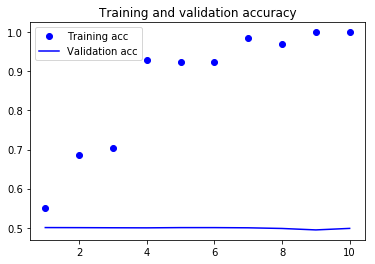

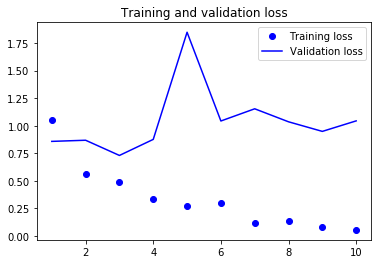

In [17]:
# Plotting the performance
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# Traing the same model without pretrained word embeddings
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

model.compile(optimizer = 'rmsprop',
             loss='binary_crossentropy',
             metrics = ['acc'])

history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_data = (x_val,y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.6962 - acc: 0.4900 - val_loss: 0.6943 - val_acc: 0.4975
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5058 - a

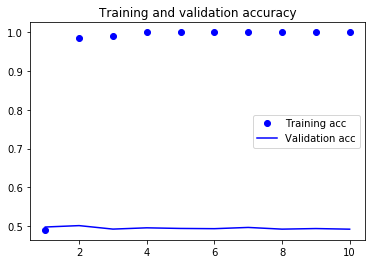

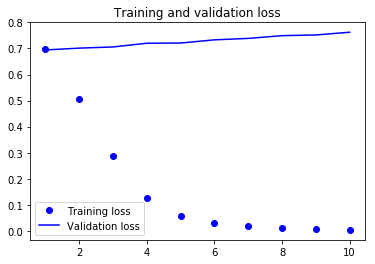

In [20]:
# Plotting the performance
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
# Tokenize the data of the test set
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg','pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] =='txt':
            f=open(os.path.join(dir_name,fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [22]:
# Evaluating the model on the test set
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

[]

## 1.4 Wrapping up
- Use the *Embedding layer* in a Keras model to learn task-specific token embeddings
- Use pretrained word embeddings to get an extra boost on small natural-language-processing problems